In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset

In [41]:
data = pd.read_csv('./../derived_data_csv/new_features_added_min.csv')

In [42]:
data.columns

Index(['city_id', 'date', 'avg_temp_c', 'min_temp_c', 'max_temp_c',
       'precipitation_mm', 'snow_depth_mm', 'avg_wind_dir_deg',
       'avg_wind_speed_kmh', 'day_of_week', 'day_of_year', 'month',
       'temp_range'],
      dtype='object')

In [43]:
# Python
selected_columns_to_exclude = ['date', 'city_id',
                               'snow_depth_mm']  # replace with your column names
features = [col for col in data.columns if col not in selected_columns_to_exclude]

target = 'avg_temp_c'

# Scaling features
scaler = StandardScaler()
# Python
numerical_features = data.select_dtypes(include=[np.number]).columns.tolist()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

In [44]:
# print(data[features].head())
data = data.fillna(-1)
data.head()

,city_id,date,avg_temp_c,min_temp_c,max_temp_c,precipitation_mm,snow_depth_mm,avg_wind_dir_deg,avg_wind_speed_kmh,day_of_week,day_of_year,month,temp_range
0,C001,2014-01-01,-1.266071,-1.601981,-1.176193,-1.0,-1.0,-0.072559,-0.828630,-0.500611,-1.727467,-1.601858,0.875295
1,C001,2014-01-02,-0.993418,-0.832364,-1.013461,-1.0,-1.0,-0.195858,-0.209017,-0.000590,-1.717983,-1.601858,-0.522623
2,C001,2014-01-03,-1.165089,-1.272145,-0.946454,-1.0,-1.0,-1.000000,-0.893852,0.499431,-1.708498,-1.601858,0.665607
3,C001,2014-01-04,-1.165089,-1.072245,-1.013461,-1.0,-1.0,1.094038,0.002955,0.999452,-1.699014,-1.601858,0.036544
4,C001,2014-01-05,-1.064106,-1.412076,-0.668852,-1.0,-1.0,-1.000000,-1.024297,1.499473,-1.689529,-1.601858,1.667449


In [81]:
# Create sequences for each city
def create_sequences(df, features, target, seq_length=35, pred_length=7):
    X = []
    y = []
    for i in range(len(df) - seq_length - pred_length + 1):
        X.append(df[features].iloc[i:i+seq_length].values)
        y.append(df[target].iloc[i+seq_length:i+seq_length+pred_length].values)
    return np.array(X), np.array(y)


# Split data by city and create sequences
city_data = data.groupby('city_id')
X_list = []
y_list = []
X_list_final = []
last_dates = []
seq_length = 35
for i, (_, group) in enumerate(city_data):
    if i == 5:  # stop after processing 5 cities
        break
    X, y = create_sequences(group, features, target, seq_length=seq_length)
    X_list.append(X)
    y_list.append(y)
    X_last = group[features].iloc[-seq_length:].values
    X_list_final.append(X_last)

In [48]:
print(len(X_list))
print(len(y_list))
print(len(X_list[0]))
print(len(y_list[0]))
lengths = [len(element) for element in X_list]
print(lengths)
print(len(X_list[0][0]))

5
5
1785
1785
[1785, 1762, 1782, 1785, 1785]
35


In [66]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from matplotlib import pyplot as plt

In [101]:
print(np.concatenate(X_list, axis=0).shape)
print(np.array(X_list_final).shape)

(8899, 35, 10)
(5, 35, 10)


In [58]:

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [102]:
# Convert to PyTorch tensors
X_predict_tensor = torch.tensor(X_list_final, dtype=torch.float32)
predict_dataset = TensorDataset(X_predict_tensor)
predict_loader = DataLoader(predict_dataset, batch_size=1, shuffle=False)

In [103]:
# For the train loader
for i, (inputs, targets) in enumerate(train_loader):
    if i == 1:
        break
    print(f'Train Inputs Shape: {inputs.shape}, Train Targets Shape: {targets.shape}')
# For the test loader
for i, (inputs, targets) in enumerate(test_loader):
    if i == 1:
        break
    print(f'Test Inputs Shape: {inputs.shape}, Test Targets Shape: {targets.shape}')
for i, (inputs,) in enumerate(predict_loader):
    if i == 1:
        break
    print(f'Predict Inputs Shape: {inputs.shape}')

Train Inputs Shape: torch.Size([32, 35, 10]), Train Targets Shape: torch.Size([32, 7])
Test Inputs Shape: torch.Size([32, 35, 10]), Test Targets Shape: torch.Size([32, 7])
Predict Inputs Shape: torch.Size([1, 35, 10])


In [61]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size,
                            num_layers=num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_layer_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_layer_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Define model, loss function, and optimizer
input_size = len(features)
hidden_layer_size = 64
output_size = 7
num_layers = 2
dropout = 0.5

model = LSTMModel(input_size, hidden_layer_size,
                  output_size, num_layers, dropout)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [62]:
def train_model(model, criterion, optimizer, dataloader):
    model.train()
    total_loss = 0

    for data, target in dataloader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

In [63]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in dataloader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    return total_loss / len(dataloader)

In [73]:
def model_fit(model, criterion, optimizer, train_dataloader, test_dataloader, num_epochs=25, patience=10, checkpoint=40):
    train_losses = []
    test_losses = []

    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss = train_model(
            model, criterion, optimizer, train_dataloader)
        test_loss = evaluate_model(
            model, criterion, test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
        if (epoch + 1) % checkpoint == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Test Loss = {test_loss:.4f}")

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

    return model, train_losses, test_losses

In [74]:
def plot_losses(train_losses, test_losses, figsize=(6, 3)):
    plt.figure(figsize=figsize)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.title('Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch 5/100: Train Loss = 0.0544, Test Loss = 0.0540
Epoch 10/100: Train Loss = 0.0516, Test Loss = 0.0520
Epoch 15/100: Train Loss = 0.0489, Test Loss = 0.0491
Epoch 20/100: Train Loss = 0.0470, Test Loss = 0.0470
Epoch 25/100: Train Loss = 0.0444, Test Loss = 0.0432
Epoch 30/100: Train Loss = 0.0420, Test Loss = 0.0412
Epoch 35/100: Train Loss = 0.0409, Test Loss = 0.0404
Epoch 40/100: Train Loss = 0.0388, Test Loss = 0.0386
Epoch 45/100: Train Loss = 0.0387, Test Loss = 0.0386
Epoch 50/100: Train Loss = 0.0363, Test Loss = 0.0359
Epoch 55/100: Train Loss = 0.0357, Test Loss = 0.0356
Epoch 60/100: Train Loss = 0.0349, Test Loss = 0.0357
Early stopping triggered


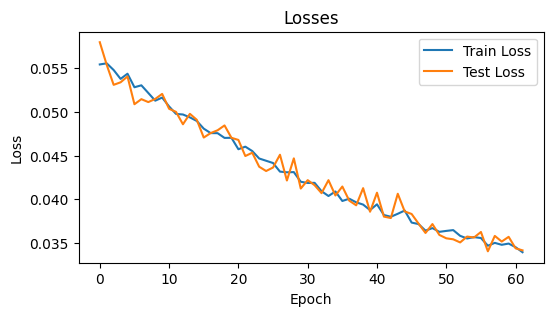

In [76]:
model, train_losses, test_losses = model_fit(
    model, loss_function, optimizer, train_loader, test_loader, num_epochs=100, checkpoint=5, patience=5)
plot_losses(train_losses, test_losses)

In [130]:
from datetime import datetime, timedelta

# Initialize an empty DataFrame
submission_df = pd.DataFrame(
    columns=['submission_ID', 'city_id', 'date', "avg_temp_c"])
# Initialize an non-empty DataFrame
submission_df = pd.DataFrame(
    {'submission_ID': [0], 'city_id': ['C000'], 'date': [datetime.strptime('2019-01-01', '%Y-%m-%d')], "avg_temp_c": [0.0]})

# Initialize the submission ID
submission_ID = 1
date = datetime.strptime('2019-01-01', '%Y-%m-%d')
# Iterate over the list of sequences
for i, (inputs,) in enumerate(predict_loader):    
    # Generate the city_id
    city_id = 'C' + str(i+1).zfill(3)

    # Use the model to predict the next 14 days
    predictions = model(inputs)
    predictions = predictions.detach().numpy().flatten()
    # For each day in the prediction
    for j in range(7):
        # Append a new row to the DataFrame
        new_entry = pd.DataFrame(
            {'submission_ID': [submission_ID], 'city_id': [city_id], 'date': [date], "avg_temp_c": [predictions[j]]}, index=[0])
        submission_df = pd.concat([submission_df, new_entry], ignore_index=True)
        # Increment the submission ID
        date += timedelta(days=1)
        submission_ID += 1
    date = datetime.strptime('2019-01-01', '%Y-%m-%d')
# Drop the initial row
submission_df = submission_df.iloc[1:]

In [131]:
print(submission_df)

    submission_ID city_id       date  avg_temp_c
1               1    C001 2019-01-01   -0.694077
2               2    C001 2019-01-02   -0.594138
3               3    C001 2019-01-03   -0.542195
4               4    C001 2019-01-04   -0.545855
5               5    C001 2019-01-05   -0.595523
6               6    C001 2019-01-06   -0.695018
7               7    C001 2019-01-07   -0.812104
8               8    C002 2019-01-01   -0.493930
9               9    C002 2019-01-02   -0.498740
10             10    C002 2019-01-03   -0.540514
11             11    C002 2019-01-04   -0.569864
12             12    C002 2019-01-05   -0.587256
13             13    C002 2019-01-06   -0.615226
14             14    C002 2019-01-07   -0.639478
15             15    C003 2019-01-01    0.806349
16             16    C003 2019-01-02    0.834389
17             17    C003 2019-01-03    0.851547
18             18    C003 2019-01-04    0.866967
19             19    C003 2019-01-05    0.843815
20             20   